# **SPEECH EMOTION RECOGNITION**




# EXPLORATORY DATA ANALYSIS


In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# path to the directory
RAVD = "/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/"

In [ ]:
dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    fname = os.listdir(RAVD + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVD + i + '/' + f)


RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_surprise       96
male_disgust        96
female_happy        96
female_sad          96
female_fear         96
female_angry        96
female_surprise     96
female_disgust      96
Name: count, dtype: int64

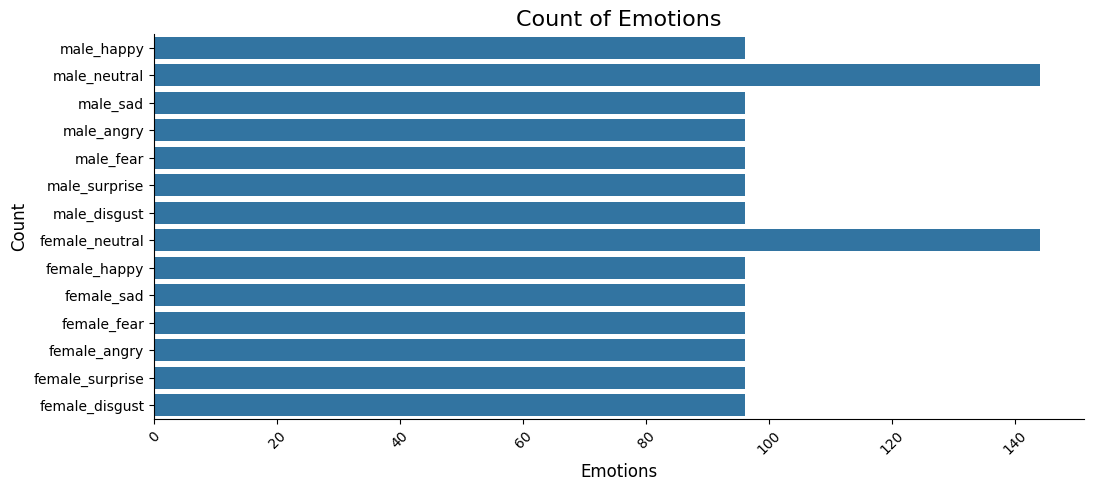

In [ ]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAVD_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
# Female Happy
fRA1= RAVD + 'Actor_08/03-01-03-02-02-01-08.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1)


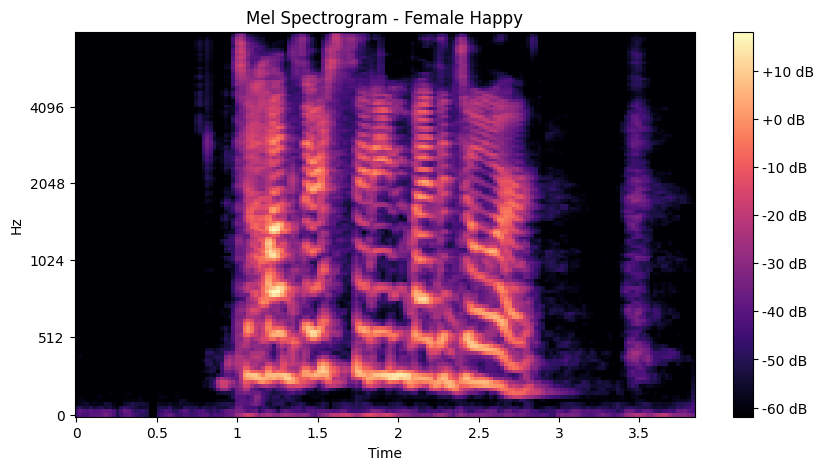

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Happy')
plt.colorbar(format='%+2.0f dB')

In [ ]:
#Female Fear
fRA2=RAVD +'Actor_08/03-01-06-01-01-01-08.wav'
data, sr = librosa.load(fRA2)
ipd.Audio(fRA2)

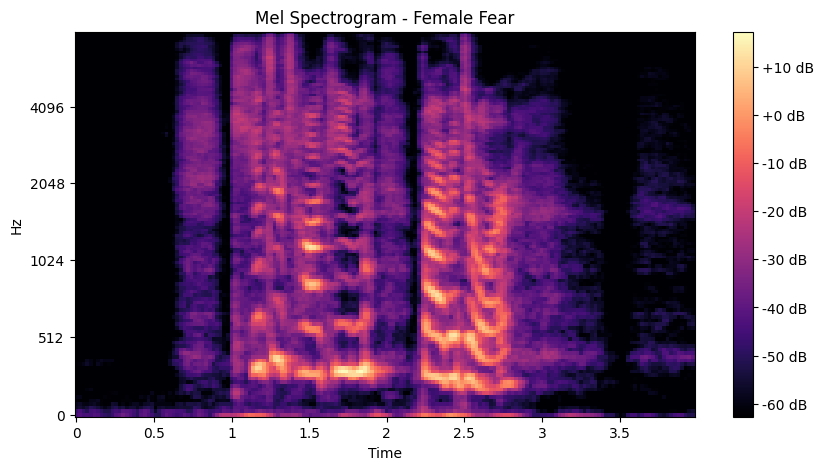

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fear')
plt.colorbar(format='%+2.0f dB');

In [ ]:
# Female Disgust
fRA1 =RAVD +'Actor_20/03-01-08-02-02-02-20.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1)

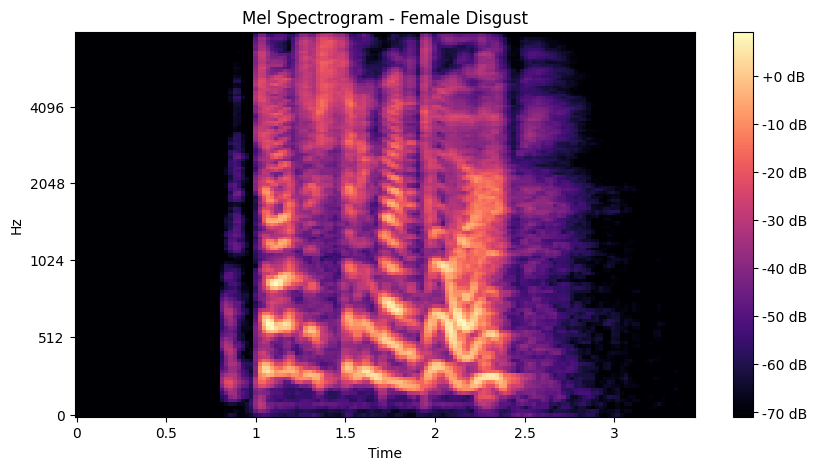

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Disgust')
plt.colorbar(format='%+2.0f dB');

In [ ]:
# Male Fearfull
fRA1 = RAVD + 'Actor_19/03-01-04-01-02-01-19.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1)

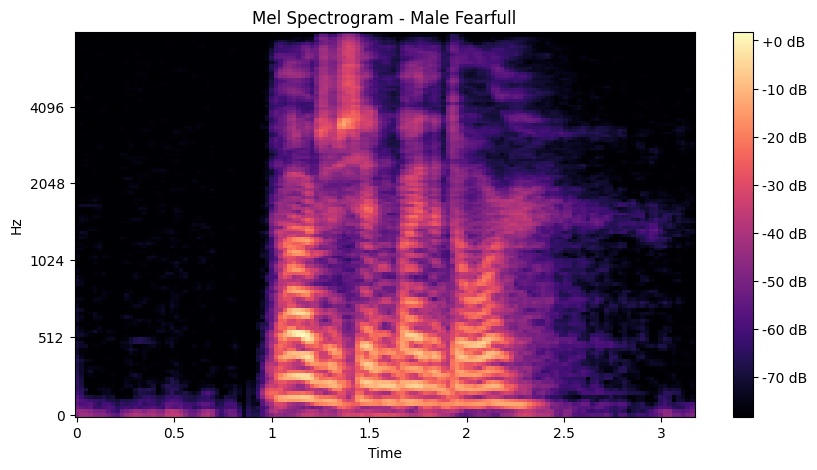

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Fearfull')
plt.colorbar(format='%+2.0f dB');

# DATA AUGMENTATION



In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
# Trying different functions above
path = np.array(RAVD_df['path'])[471]
data, sample_rate = librosa.load(path)

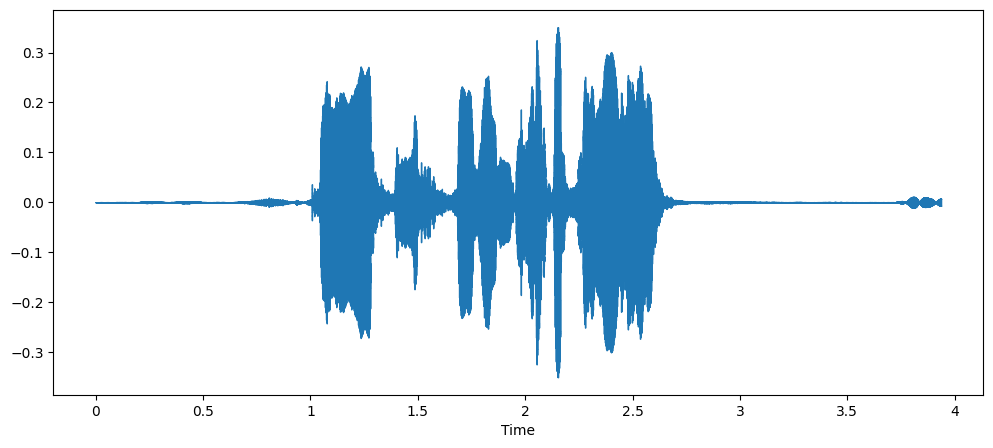

In [ ]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
Audio(path)

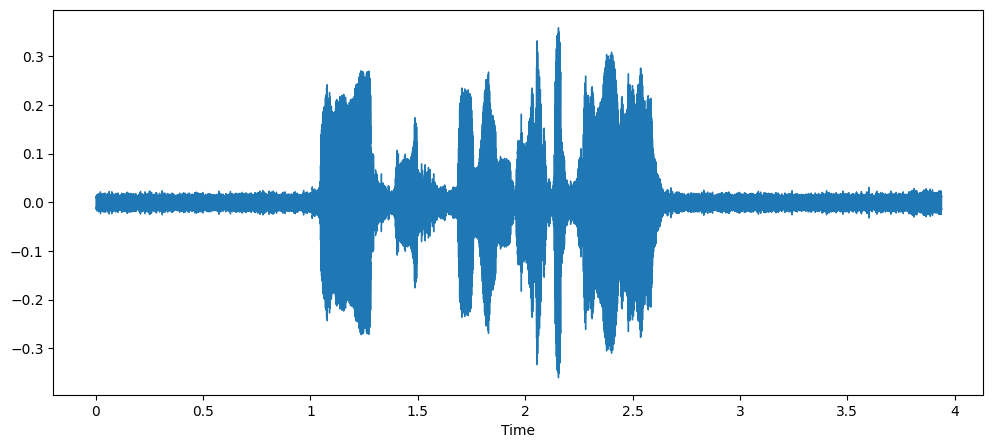

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sample_rate)

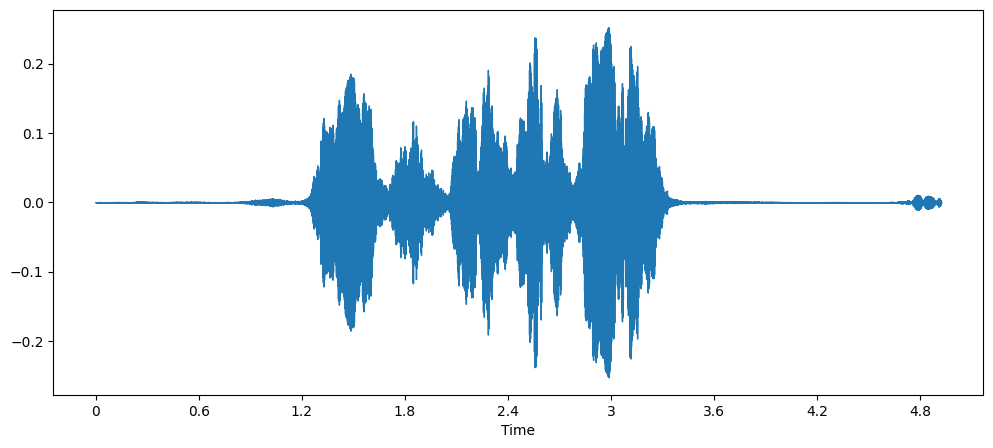

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

# Assuming 'data' and 'sr' are already defined
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

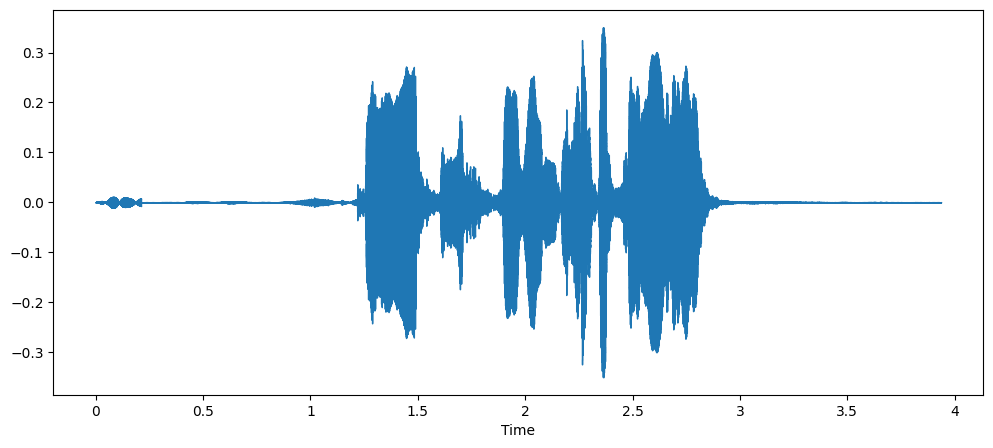

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sample_rate)

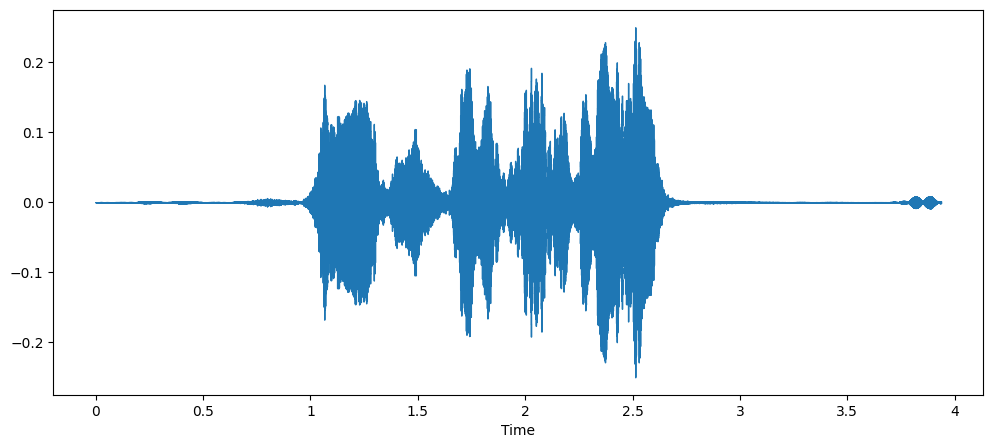

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=pitch_factor)

# Assuming 'data' and 'sr' are already defined
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# FEATURE EXTRACTION

In [ ]:

def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [ ]:
RAVD_df.head()

,labels,source,path
0,male_happy,RAVDESS,/content/drive/MyDrive/speech-emotion-recognit...
1,male_neutral,RAVDESS,/content/drive/MyDrive/speech-emotion-recognit...
2,male_neutral,RAVDESS,/content/drive/MyDrive/speech-emotion-recognit...
3,male_neutral,RAVDESS,/content/drive/MyDrive/speech-emotion-recognit...
4,male_neutral,RAVDESS,/content/drive/MyDrive/speech-emotion-recognit...


In [ ]:
X, Y = [], []
for path, emotion in zip(RAVD_df['path'], RAVD_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['labels'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-527.593811,90.176964,-27.783163,24.734629,-17.078173,9.592499,-27.342495,-6.599154,-18.633366,-11.736102,...,-13.649584,0.979639,-10.611071,-5.111373,-5.472372,-7.795131,-8.164783,-2.579542,-8.664580,male_happy
1,-457.636648,63.845390,-12.548859,10.922606,-7.191008,-0.323929,-18.990933,-11.783106,-14.804537,-12.676058,...,-9.643505,-2.321581,-8.127862,-6.450386,-4.217156,-8.979703,-5.917771,-3.241988,-7.845977,male_happy
2,-578.617126,84.023788,-27.491590,21.599731,-19.204424,6.121158,-31.592543,-6.354903,-22.203783,-9.095275,...,-11.978481,0.458983,-12.708385,-5.144249,-7.516799,-9.005713,-7.055140,-3.428950,-10.695880,male_happy
3,-654.261780,82.973686,-10.223094,28.501028,-2.694186,11.063918,-8.864511,-3.794175,-15.606810,-4.145116,...,-4.571629,2.582543,-7.355880,0.479849,-1.751774,-3.555675,-5.115199,1.152229,-1.791787,male_neutral
4,-380.206156,18.963698,9.276331,8.303434,2.979446,1.673423,-1.838943,-5.347362,-5.777070,-3.738911,...,-0.788971,-1.034497,-1.695080,-0.721549,-0.076729,-2.014045,-2.542265,-0.533709,-1.325581,male_neutral


In [ ]:
# can use this directly from saved feature .csv file
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-527.593811,90.176964,-27.783163,24.734629,-17.078173,9.592499,-27.342495,-6.599154,-18.633366,-11.736102,...,-13.649584,0.979639,-10.611071,-5.111373,-5.472372,-7.795131,-8.164783,-2.579542,-8.664580,male_happy
1,-457.636648,63.845390,-12.548859,10.922606,-7.191008,-0.323929,-18.990933,-11.783106,-14.804537,-12.676058,...,-9.643505,-2.321581,-8.127862,-6.450386,-4.217156,-8.979703,-5.917771,-3.241988,-7.845977,male_happy
2,-578.617126,84.023788,-27.491590,21.599731,-19.204424,6.121158,-31.592543,-6.354903,-22.203783,-9.095275,...,-11.978481,0.458983,-12.708385,-5.144249,-7.516799,-9.005713,-7.055140,-3.428950,-10.695880,male_happy
3,-654.261780,82.973686,-10.223094,28.501028,-2.694186,11.063918,-8.864511,-3.794175,-15.606810,-4.145116,...,-4.571629,2.582543,-7.355880,0.479849,-1.751774,-3.555675,-5.115199,1.152229,-1.791787,male_neutral
4,-380.206156,18.963698,9.276331,8.303434,2.979446,1.673423,-1.838943,-5.347362,-5.777070,-3.738911,...,-0.788971,-1.034497,-1.695080,-0.721549,-0.076729,-2.014045,-2.542265,-0.533709,-1.325581,male_neutral


# DATA PREPROCESSING

In [ ]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# Train and Test Split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 14), (1080, 20), (1080, 14))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 14), (1080, 20), (1080, 14))

# IMPLOYING MODELS

## **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=4)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
y_pred=clf1.predict(x_test)

In [ ]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.587
Test set score: 0.421


## **MLP CLASSIFIER**

In [ ]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=270, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=400)

In [ ]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Training set score: 0.933
Test set score: 0.627


# GRU

In [ ]:
# Reshape for GRU
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
model03 = Sequential()
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, activation='tanh'))
model03.add(Dropout(0.3))
model03.add(Dense(units=14))
model03.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
model03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 20, 50)            15300     
                                                                 
 dropout_2 (Dropout)         (None, 20, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)                1

In [ ]:
hist=model03.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=200)

Epoch 1/100
17/17 [==============================] - 2s 91ms/step - loss: 0.0646 - accuracy: 0.1997 - val_loss: 0.0637 - val_accuracy: 0.2194
Epoch 2/100
17/17 [==============================] - 1s 83ms/step - loss: 0.0645 - accuracy: 0.1960 - val_loss: 0.0637 - val_accuracy: 0.2231
Epoch 3/100
17/17 [==============================] - 2s 97ms/step - loss: 0.0646 - accuracy: 0.2022 - val_loss: 0.0637 - val_accuracy: 0.2185
Epoch 4/100
17/17 [==============================] - 1s 87ms/step - loss: 0.0645 - accuracy: 0.1932 - val_loss: 0.0637 - val_accuracy: 0.2241
Epoch 5/100
17/17 [==============================] - 1s 85ms/step - loss: 0.0644 - accuracy: 0.2009 - val_loss: 0.0637 - val_accuracy: 0.2176
Epoch 6/100
17/17 [==============================] - 2s 147ms/step - loss: 0.0645 - accuracy: 0.1948 - val_loss: 0.0637 - val_accuracy: 0.2204
Epoch 7/100
17/17 [==============================] - 1s 86ms/step - loss: 0.0643 - accuracy: 0.1954 - val_loss: 0.0637 - val_accuracy: 0.2204
Epoch

In [ ]:
print("Accuracy of our model on test data : " , model03.evaluate(X_test,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 8ms/step - loss: 0.0631 - accuracy: 0.2370
Accuracy of our model on test data :  23.70370328426361 %


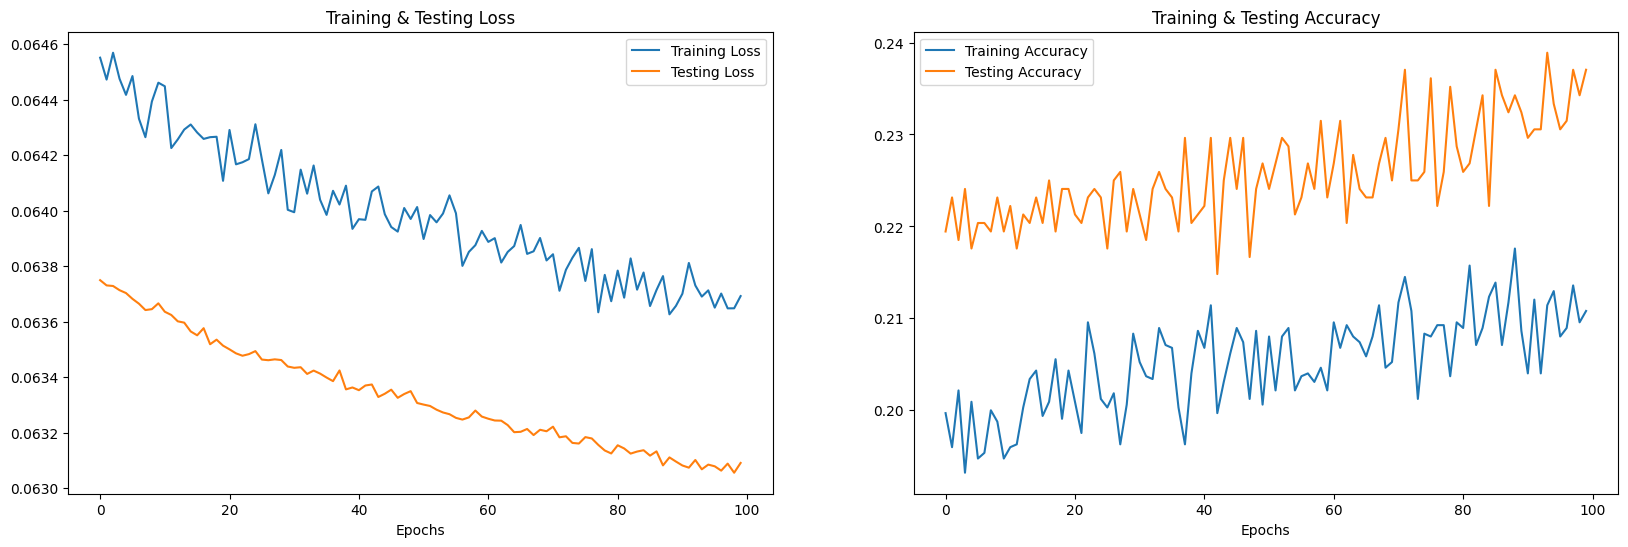

In [ ]:
#GRU
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
#GRU
pred_test = model03.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

34/34 [==============================] - 2s 10ms/step


,Predicted Labels,Actual Labels
0,female_fear,female_fear
1,male_neutral,male_angry
2,female_happy,female_surprise
3,female_happy,female_happy
4,female_neutral,female_angry
5,female_disgust,female_surprise
6,female_neutral,male_disgust
7,male_neutral,male_neutral
8,male_neutral,female_disgust
9,male_neutral,male_angry


## **CNN**

In [ ]:
#CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 20, 1), (3240, 14), (1080, 20, 1), (1080, 14))

In [ ]:
#CNN
import tensorflow as tf
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(14, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 10, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 1024)           0         
 g1D)                                                            
                                                      

In [ ]:
#CNN
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
51/51 [==============================] - 11s 43ms/step - loss: 2.6039 - accuracy: 0.0935 - val_loss: 2.6291 - val_accuracy: 0.0833
Epoch 2/150
51/51 [==============================] - 1s 26ms/step - loss: 2.5397 - accuracy: 0.1238 - val_loss: 2.6204 - val_accuracy: 0.0722
Epoch 3/150
51/51 [==============================] - 1s 26ms/step - loss: 2.4687 - accuracy: 0.1590 - val_loss: 2.6161 - val_accuracy: 0.0833
Epoch 4/150
51/51 [==============================] - 1s 26ms/step - loss: 2.3879 - accuracy: 0.1756 - val_loss: 2.5886 - val_accuracy: 0.1287
Epoch 5/150
51/51 [==============================] - 1s 26ms/step - loss: 2.3120 - accuracy: 0.2025 - val_loss: 2.5367 - val_accuracy: 0.1296
Epoch 6/150
51/51 [==============================] - 1s 26ms/step - loss: 2.2536 - accuracy: 0.2302 - val_loss: 2.3904 - val_accuracy: 0.2417
Epoch 7/150
51/51 [==============================] - 1s 26ms/step - loss: 2.1950 - accuracy: 0.2333 - val_loss: 2.3558 - val_accuracy: 0.2185
Epoch

In [ ]:
#CNN
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 8ms/step - loss: 1.0957 - accuracy: 0.8620
Accuracy of our model on test data :  86.20370626449585 %


# Loss Accuracy Plot Using CNN

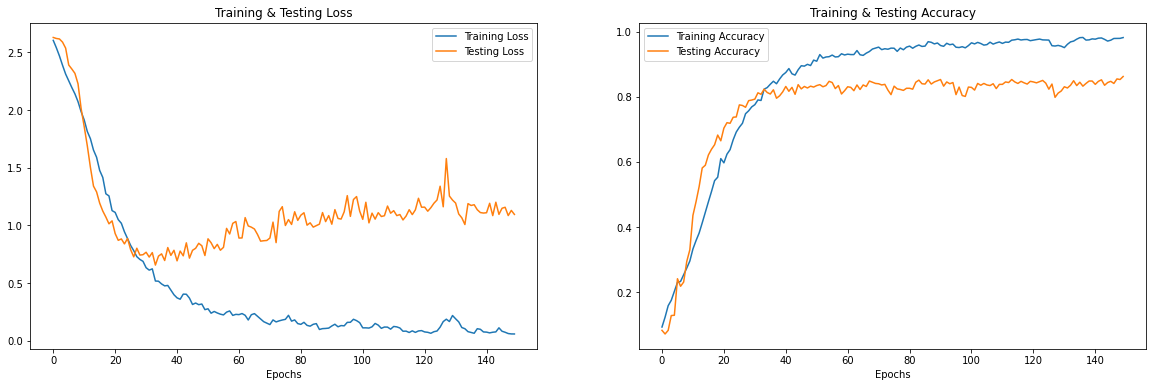

In [ ]:
#CNN
epochs = [i for i in range(150)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
#CNN
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,female_sad,female_sad
1,male_disgust,male_happy
2,female_surprise,female_surprise
3,female_angry,female_angry
4,female_surprise,female_fear
5,female_sad,female_sad
6,male_surprise,male_disgust
7,male_sad,male_sad
8,female_surprise,female_surprise
9,male_neutral,male_neutral


# Confusion Matrix Using CNN

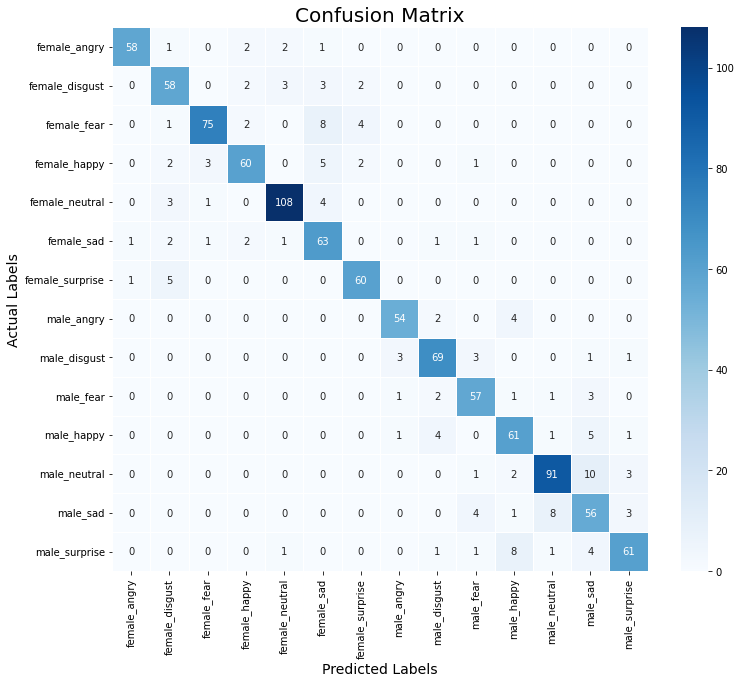

In [ ]:
#CNN
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Classification Report Using CNN

In [ ]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.97      0.91      0.94        64
 female_disgust       0.81      0.85      0.83        68
    female_fear       0.94      0.83      0.88        90
   female_happy       0.88      0.82      0.85        73
 female_neutral       0.94      0.93      0.94       116
     female_sad       0.75      0.88      0.81        72
female_surprise       0.88      0.91      0.90        66
     male_angry       0.92      0.90      0.91        60
   male_disgust       0.87      0.90      0.88        77
      male_fear       0.84      0.88      0.86        65
     male_happy       0.79      0.84      0.81        73
   male_neutral       0.89      0.85      0.87       107
       male_sad       0.71      0.78      0.74        72
  male_surprise       0.88      0.79      0.84        77

       accuracy                           0.86      1080
      macro avg       0.86      0.86      0.86      1080
   weighted avg       0.87   